In [1]:
# utilities
import pandas as pd
import re
import time
import matplotlib.pyplot as plt

# nlp
import nltk
nltk.download('stopwords')
nltk.download('punkt') 
nltk.download('wordnet') 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # !pip install vaderSentiment

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odemunoogelohwohor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/odemunoogelohwohor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/odemunoogelohwohor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# News Headlines Cleaner
This is important for visualizations and if we use Sentiment 140.

In [2]:
class NewsHeadlineCleaner:
  def __init__(self):
    self.stop_words = set(stopwords.words('english'))

  def lowercase(self, news):
    ''' Each text is converted to lowercase. '''
    return news.lower()
  
  def replace_url(self, news):
    ''' Links starting with “Http” or “https” or “www” are replaced by “URL” '''
    url_regex = re.compile(r'(http[s]?://|www\.)\S+')
    return url_regex.sub('URL', news) 

  def remove_nonalpha(self, news):
    ''' Replacing characters except Digits and Alphabets with space.'''
    nonalpha_regex = re.compile(r'[^a-zA-Z0-9]')
    return nonalpha_regex.sub(" ", news)

  def convert_dollars(self, match):
    ''' converts $80.00to 80 dollars 0 cents'''
    num = float(match.group(1))
    dollars = int(num)
    cents = int(round((num - dollars) * 100))
    dollars_str = str(dollars)
    cents_str = str(cents)
    return f"{dollars_str} dollars {cents_str} cents"
  
  def match_dollars(self, news):
    ''' matches $80.00 to 80 dollars 0 cents'''
    regex = r"\$(\d+\.\d+)"
    matches = re.findall(regex, news)
    output_str = re.sub(regex, self.convert_dollars, news)
    return output_str
  
  def convert_pershare(self, match):
    ''' converts $80.00/Share to 80 dollars 0 cents per share'''
    num = float(match.group(1))
    dollars = int(num)
    cents = int(round((num - dollars) * 100))
    dollars_str = str(dollars)
    cents_str = str(cents)
    return f"{dollars_str} dollars {cents_str} cents per share"

  def match_pershare(self, news):
    ''' matches $80.00/Share to 80 dollars 0 cents per share'''
    regex = r"\$(\d+\.\d+)/Share"
    matches = re.findall(regex, news)
    output_str = re.sub(regex, self.convert_pershare, news)
    return output_str
  
  def replace_percent(self, news):
    ''' replace 40% with 40 percent'''
    return news.replace("%", " percent")

  def remove_stop_short_words(self, news):
    ''' English words that do not add much meaning to a sentence are removed
        and Words with a length of less than two are eliminated.'''
    words = nltk.word_tokenize(news)
    words = [word for word in words if word not in self.stop_words and len(word) >= 2]
    return ' '.join(words)
  
  def remove_one_word(self, news):
    ''' English words less than two are eliminated.'''
    words = nltk.word_tokenize(news)
    words = [word for word in words if len(word) >= 2]
    return ' '.join(words)

  def lemmatize(self, news):
    ''' Converting word to its base form. '''
    newswords = ''
    for word in news.split():
      word = WordNetLemmatizer().lemmatize(word)
      newswords += (word+' ')
    return newswords

  def clean_oneheadline(self, headline):
    ''' cleans one single headline '''
    cleaned = self.match_pershare(headline)
    cleaned = self.match_dollars(cleaned)
    cleaned = self.replace_percent(cleaned)
    cleaned = self.lowercase(cleaned)
    cleaned = self.replace_url(cleaned)
    cleaned = self.remove_nonalpha(cleaned)
    # cleaned = self.remove_one_word(cleaned)
    cleaned = self.remove_stop_short_words(cleaned)
    cleaned = self.lemmatize(cleaned)
    return cleaned

  def clean_allheadlines(self, df):
    ''' cleans all headlines in the dataframe'''
    df['news_headline_processed'] = df['news_headline'].apply(self.clean_oneheadline)
    df['news_headline_processed'] = df['news_headline_processed'].apply(lambda x: x.strip())  # remove leading and trailing white spaces
    df = df.drop_duplicates()
    df = df.drop(columns=['news_headline'])
    df = df.rename(columns={'news_headline_processed': 'news_headline'})
    return df

In [3]:
# method for processing newss
def process_news_dataframe(df):
  headlineCleaner = NewsHeadlineCleaner()
  
  t = time.time()
  df_processed = headlineCleaner.clean_allheadlines(df)
  print(f'Text Preprocessing complete.')
  print(f'Time Taken: {round(time.time()-t)} seconds')
  return df_processed

In [4]:
# Load the CSV file
df = pd.read_csv('../data/zoom/2022_full_webull_zoom_stock_news.csv')
df.head()

# Process news
df_processed = process_news_dataframe(df)
df_processed.head()

# Save the cleaned data to a new CSV file
df_processed.to_csv('cleaned_2022_full_webull_zoom_stock_news.csv', index=False)


Text Preprocessing complete.
Time Taken: 2 seconds


# EDA and Visualizations on Cleaned Headlines

## Frequency Distribution

In [5]:
# Create a frequency distribution of the cleaned words
def frequency_distribution(df_title, zoom_stock_words, stock_words):
    all_words = []
    for text in df[df_title]:
        all_words.extend(text.split())
    freq_dist = nltk.FreqDist(all_words)

    # pop some obvious words: 
    # display(freq_dist)

    for word in zoom_stock_words:
        freq_dist.pop(word)

    for word in stock_words:
        freq_dist.pop(word)

    return freq_dist

## Wordcloud on top 100 words

In [6]:
# Create a wordcloud based on the frequency distribution (top 100 words)
def stock_wordcloud(freq_dist, year, stock):
    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(freq_dist)

    # Plot the wordcloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.title("100 most frequent words related to " + stock + " stocks across news headlines in " + year)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig("wordcloud_" + year + "_" + stock + "_news.png")
    plt.show()

## Barplot on top 20 words

In [7]:
# extract the top 20 words and their frequencies
def stock_barplot(freq_dist, stock, year):
    top_words = freq_dist.most_common(20)[::-1]
    top_words_dict = dict(top_words)

    # create a bar plot
    plt.barh(list(top_words_dict.keys()), list(top_words_dict.values()))

    # set the x-axis label
    plt.xlabel('Frequency')

    # set the y-axis label
    plt.ylabel('Words')

    # display the plot
    plt.title("20 most frequent words related to " + stock + " stocks across news headlines in " + year)
    plt.savefig("barplot_" + year + "_" + stock + "_news.png")
    plt.show()

,date,news_headline
0,12/30/2022,tracking philippe laffont coatue management po...
1,12/29/2022,zoom share climb percent effort claim late dec...
2,12/29/2022,insider sell zoom video communication
3,12/28/2022,going cathie wood ark innovation etf arkk
4,12/28/2022,cathie wood channel warren buffett year end in...


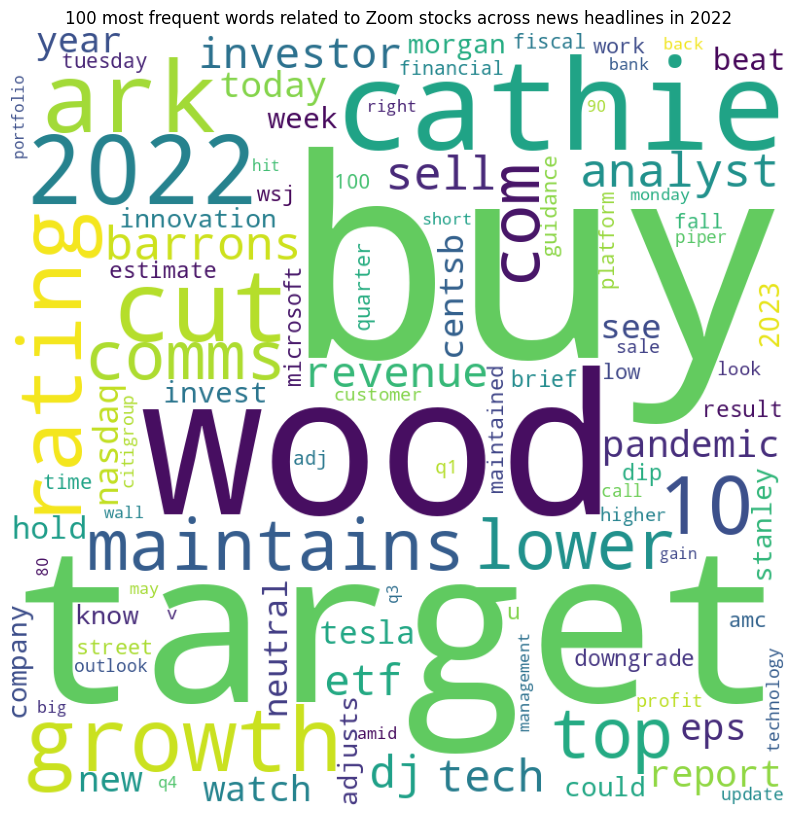

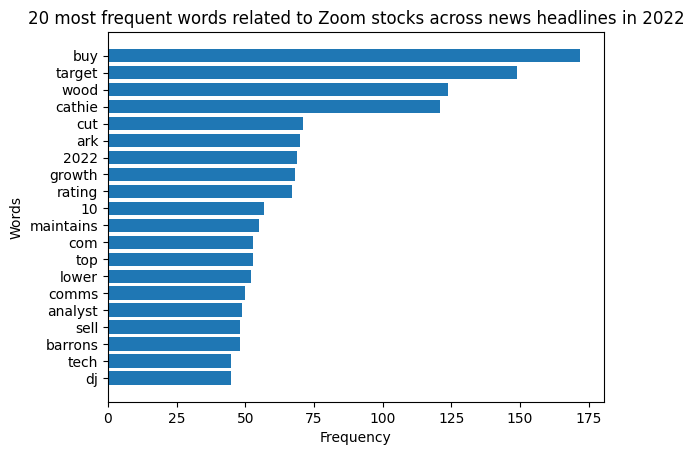

In [9]:
# Load the cleaned CSV file
df = pd.read_csv('cleaned_2022_full_webull_zoom_stock_news.csv')
display(df.head())

# get freq distribution
df_title = 'news_headline'
zoom_stock_words = ['zoom', 'video', 'communication', 'zm']
stock_words = ['stock', 'dollar', 'cent', 'price', 'percent', 'earnings', 'market', 'share', 'inc', 'say', 'per']

freq_dist = frequency_distribution(df_title, zoom_stock_words, stock_words)
    
# plot stock words
year = "2022"
stock = "Zoom"
stock_wordcloud(freq_dist, year, stock)
stock_barplot(freq_dist, stock, year)

# VADER Sentiment Analysis on Raw Headlines

Sentiment140 is a machine learning-based model that uses a large corpus of labeled data to classify text as positive, negative, or neutral. It can be useful if you have a large dataset and you want to classify the sentiment of text in a relatively automated way. However, it may not be as accurate or nuanced as VADER in certain contexts, and may require more training data and tuning to perform well.

VADER, on the other hand, is a rule-based model that is specifically designed for analyzing social media text. It has been shown to perform well in analyzing short, informal text such as tweets, and it takes into account sentiment-laden words, emoticons, and punctuation. It also has a built-in mechanism for handling negations and intensifiers, which can be important for accurately assessing sentiment in context. Overall, VADER can be a good choice if you are analyzing text from social media or other informal contexts where language may be more nuanced and difficult to classify using traditional sentiment analysis methods.

VADER is designed to work well **without preprocessing steps** such as removing punctuation and stopwords, but you can still experiment with preprocessing and see if it improves the accuracy of your sentiment analysis.

In [10]:
# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

## Calculate the sentiment scores for each news headline using VADER

In [13]:
# Define a function to calculate the sentiment scores for each news headline
def calculate_sentiment_scores(headline):
    scores = analyzer.polarity_scores(headline)
    return scores['compound']

# Define a function to label the sentiment based on the sentiment score
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def each_headline_sentiment(df, df_col, stock, year):
    # Add a new column to your dataframe to store the sentiment scores
    df['sentiment_score'] = df[df_col].apply(calculate_sentiment_scores)

    # Add another column to your dataframe to store the sentiment labels
    df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

    # Print the dataframe with the sentiment scores and labels
    display(df.head())
    df.to_csv(stock + '_sentiment_'+ year + '_webullnews.csv', index=False)


In [14]:
# Load the CSV file
df = pd.read_csv('../data/zoom/2022_full_webull_zoom_stock_news.csv')
df.head()

df_col = 'news_headline'
year = "2022"
stock = "Zoom"
each_headline_sentiment(df, df_col, stock, year)

,date,news_headline,sentiment_score,sentiment_label
0,12/30/2022,Tracking Philippe Laffont's Coatue Management ...,0.0000,Neutral
1,12/29/2022,Zoom shares climb 4% in effort to claim late-D...,0.5574,Positive
2,12/29/2022,Insider Sell: Zoom Video Communications,0.0000,Neutral
3,12/28/2022,What's Going On With Cathie Wood's ARK Innovat...,0.3818,Positive
4,12/28/2022,Cathie Wood Channels Warren Buffett With Year ...,0.0000,Neutral


## Calculate average sentiment per day using VADER

In [15]:
def avg_sentiment_df(analyzer, df, df_col, label_sentiment, stock, year):
    # Calculate the sentiment score for each news headline
    df['sentiment_score'] = df[df_col].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    # Convert the date column to datetime format
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

    # Calculate the average sentiment score by day
    df_avg = df.groupby('date').agg({'sentiment_score': 'mean'})

    # Apply the label_sentiment function to the sentiment_score column
    df_avg['sentiment_label'] = df_avg['sentiment_score'].apply(lambda x: label_sentiment(x))

    # Print the resulting DataFrame
    display(df_avg)
    df_avg.to_csv(stock + '_avg_sentiment_'+ year + '_webullnews.csv', index=True)


In [16]:
# Load the CSV file
df = pd.read_csv('../data/zoom/2022_full_webull_zoom_stock_news.csv')
df.head()

df_col = 'news_headline'
year = "2022"
stock = "Zoom"
avg_sentiment_df(analyzer, df, df_col, label_sentiment, stock, year)

,sentiment_score,sentiment_label
date,,
2022-01-01,0.192885,Positive
2022-01-02,0.000000,Neutral
2022-01-03,0.144718,Positive
2022-01-04,0.010080,Neutral
2022-01-05,0.000000,Neutral
...,...,...
2022-12-17,-0.421500,Negative
2022-12-20,0.458800,Positive
2022-12-28,0.210600,Positive


## Plot average VADER sentiment score per day

In [17]:
def vader_plot(df, year, stock):
    # Create a line plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df['date'], df['sentiment_score'], color='blue')

    # Set plot title and axis labels
    ax.set_title('VADER Sentiment Score for ' + year + ' ' + stock + ' Stocks News Headlines per Date')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment Score')

    # Add horizontal lines and labels for positive and negative sentiment thresholds
    ax.axhline(y=0.05, color='green', linestyle='--', label='Above Line: Positive')
    ax.axhline(y=-0.05, color='red', linestyle='--', label='Below Line: Negative')
    ax.legend()

    # Show plot
    plt.savefig(year + "_VADER_sentiment_" + stock + ".png")
    plt.show()


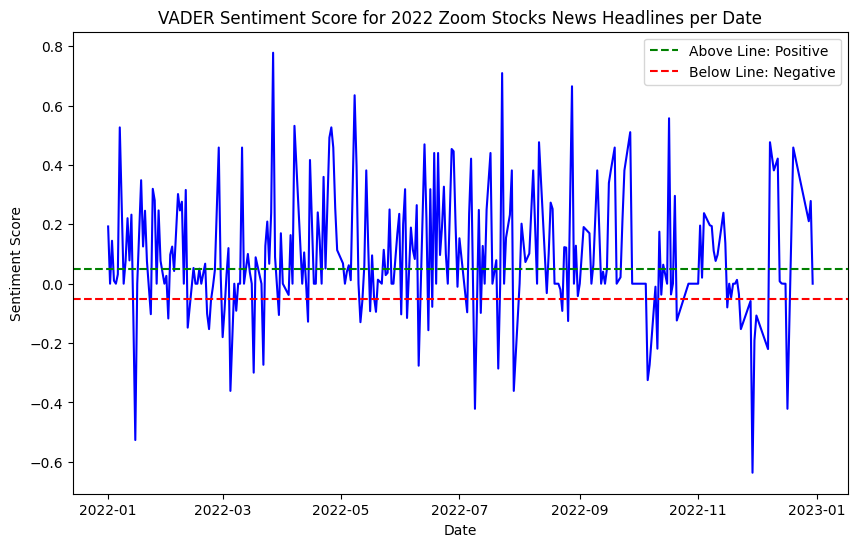

In [20]:
df = pd.read_csv('Zoom_avg_sentiment_2022_webullnews.csv', parse_dates=['date'])
vader_plot(df, year, stock)

## Plot sentiment label count

In [26]:
def count_sentiment_label(df, year, stock):
    # count the number of each sentiment label
    counts = df['sentiment_label'].value_counts()

    # create a bar plot
    plt.bar(counts.index, counts.values)

    # Set plot title
    plt.title('VADER Sentiment Labels for ' + year + ' ' + stock + ' Stocks News Headlines')

    # set the x-axis label
    plt.xlabel('Sentiment Label')

    # set the y-axis label
    plt.ylabel('Count')

    # display the plot
    plt.savefig(year + "_VADER_sentiment_count_" + stock + ".png")
    plt.show()

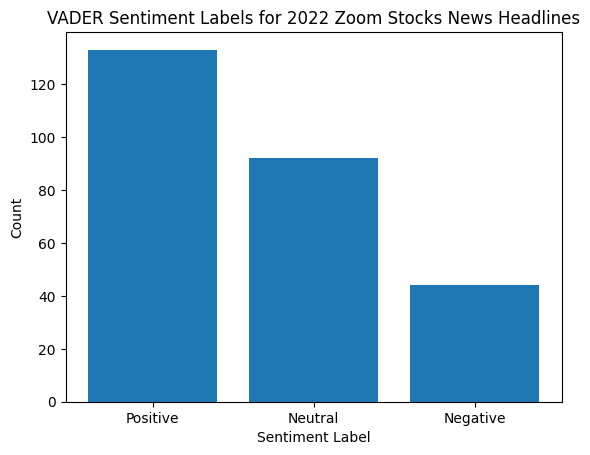

In [27]:
df = pd.read_csv('Zoom_avg_sentiment_2022_webullnews.csv', parse_dates=['date'])
count_sentiment_label(df, year, stock)